In [1]:
import torch
import os
import numpy as np
import cv2

import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from PIL import Image
from xml.dom.minidom import parse
import torch.nn.functional as F
%matplotlib inline
import torchvision
import torch.nn as nn
import random 


In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unrar x '/content/gdrive/MyDrive/images.rar' "/content"

In [ ]:
!unrar x '/content/gdrive/MyDrive/val_images.rar' "/content"


In [12]:
new_data = np.load('/content/wider_face_train_bbx_gt_final_train_data_copy(30,30).npz', allow_pickle=True)

In [13]:
new_data_val = np.load('/content/wider_face_val_bbx_gt_final_val_data(30,30).npz', allow_pickle=True)

In [14]:
full_data_new = []
for k, a in zip(new_data_val['images_path'], new_data_val['annot']):
   if len(a)<=100:
    full_data_new.append({'image_gt_bbox':a ,'image_path':k})

In [15]:
full_data = []

for k, a in zip(new_data['images_path'], new_data['annot']):
   appropiate = []
   for box in a :
     width = box[2] - box[0]
     height = box[3] - box[1]
     area = width * height 
     if  width>10 and height>10:
       appropiate.append(box)
   if len(appropiate) > 0:
      full_data.append({'image_gt_bbox':a ,'image_path':k})
   else: 
      continue

In [16]:
np.savez('/content/testing.npz',images_info=full_data_new )

In [17]:
np.savez('/content/training.npz',images_info=full_data )

In [2]:

#new
class MarkDataset(torch.utils.data.Dataset):
    def __init__(self, info_path, root_path, transforms=None):

        
        self.root_root = root_path
       
        self.infooo = np.load(info_path, allow_pickle=True)

        self.images_info = self.infooo['images_info']

        self.images_info_new = self.images_info
        
        self.transform = transforms
        
        self.size = len(self.images_info_new)
        print(self.size)

    def __getitem__(self, idx):
        Transform = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        data = self.images_info_new
        current_image_info = data[idx]
        img_path = self.root_root + current_image_info['image_path']

        gt_boxes = current_image_info['image_gt_bbox']
      

        img = Image.open(img_path)

        img = np.asarray(img)
        
   
        img_size = img.shape
  
        
        image = cv2.resize(img, (1024, 800), interpolation = cv2.INTER_AREA)

        image = torch.as_tensor( image/255 , dtype=torch.float).permute(2,0,1)
  

        image = Transform(image)
 

        scaled_bbox = np.array([ (1),  (800/img_size[0]), (1) , (800/img_size[0])]).astype('float')
        sum_check = []
        boxes = []

        for box in gt_boxes:
            sum = np.sum(box)
            if sum not in sum_check:
              box = np.asarray(box)
              box = box * scaled_bbox
              box = [0, box[0],box[1],box[2],box[3]]
              boxes.append(box)
              sum_check.append(sum)
        
        
        labels = np.ones(len(boxes))


        boxes = torch.as_tensor(boxes, dtype=torch.float)
        
  
        labels = torch.as_tensor(labels, dtype=torch.int64)        
 

 
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
     
        return image, target , img_path
 
    def __len__(self):
        return self.size

In [3]:
import utils

root = r'/content/training.npz'
test_root = r'/content/testing.npz'


root_path_trian = '/content/images/'
root_path_val = '/content/val_images/'

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


dataset = MarkDataset(root, root_path_trian , transforms = None)
dataset_test = MarkDataset(test_root, root_path_val, transforms = None )



data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True,
    collate_fn=utils.collate_fn)
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=True,
    collate_fn=utils.collate_fn)

7986
2604


In [4]:
is_cuda= False
if torch.cuda.is_available():
    is_cuda = True
print(is_cuda)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

True


In [5]:
from network_initializer import Network_Initializer

In [6]:
model = Network_Initializer(num_anchors=27, device = device, 
              sizes = [[ 16, 32, 64, 128, 256, 312, 412 ,512, 712 ]
                   ]).to(device)


parameters = model.parameters()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3
                              , momentum=0.99)

In [ ]:
epochs = 30
from train_ephocs import train_epocs

model= train_epocs(model, optimizer, data_loader, device, epochs=epochs, training_state=True )



Test


In [8]:
from tqdm import tqdm
from functools import partial
import torch
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import numpy as np
tqdm = partial(tqdm, position=0, leave=True)

def testing(model, data_loader , device, training_state=True ):
    
    for data in tqdm(data_loader):
      print('kiss')
      images = [ image.to(device) for image in data[0] ]
      num_batch =  len(images)

      ''' gradient tracking setting '''
      if not training_state:
        with torch.no_grad():
          model.eval()
          output = model( images  )
      else:
        model.train()
        output = model(images, targets)

      
     
      

      filtered_by_scores = torch.where( output['roi_scores'][0][:,1] > 0.6)
      sigmoid = nn.Sigmoid()

      scores = sigmoid( output['roi_scores'][0][:,1][filtered_by_scores] )
     
      predicted_boxes = output['bboxes'][0][filtered_by_scores]

      
      indices = torchvision.ops.nms( predicted_boxes, scores , iou_threshold=0.2  )
   

     


      true_boxes = predicted_boxes[indices]
     
   
                                         
      
      path = data[2][0]
      img = Image.open(path)
      img = np.asarray(img)
      img = cv2.resize(img, (1024, 800), interpolation = cv2.INTER_AREA)
      img2 = img.copy()
      for box in true_boxes:
          #box = box[0]
          a = int(box[0])
          b = int(box[1])
          c = int(box[2])
          d = int(box[3])
          if a>c | b>d:
            continue
          cv2.rectangle(img2 , (a,b), (c,d), (255, 0, 0), 2)
      plt.imshow(img2)  




      break
    
    return 1

MOdel parameters loading 

In [ ]:
model.load_state_dict(torch.load('/content/gdrive/MyDrive/fast-rcnn-model-save/Faster_rcnn_without_fpn.mdl'))

  0%|          | 0/2604 [00:00<?, ?it/s]


kiss
1
torch.Size([1, 46358, 4])
greater_than_zero 622


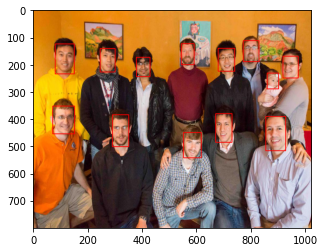

In [32]:
 
test = testing(model,  data_loader_test, device,  training_state=False )
  